In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
!git clone https://github.com/MunchkinChen/FADING.git

Cloning into 'FADING'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 30 (delta 12), reused 18 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 4.85 MiB | 20.86 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
%cd FADING

/content/FADING


In [ ]:
!pip install -U pip setuptools wheel

  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 66.5 MB/s eta 0:00:00
Using cached setuptools-80.9.0-py3-none-any.whl (1.2 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [ ]:
!pip install -q diffusers transformers accelerate safetensors \
               einops timm scipy opencv-python pillow tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, shutil
import numpy as np
import pandas as pd

# === Customize these ===
CSV_PATH  = "/content/drive/MyDrive/subsample.csv"   # CSV
IMG_ROOT  = "/content/drive/MyDrive/subsample"       # where images live

OUT_IMG_DIR = "specialization_data/training_images"
os.makedirs(OUT_IMG_DIR, exist_ok=True)
os.makedirs("specialization_data", exist_ok=True)

df = pd.read_csv(CSV_PATH)

rows = []
for _, row in df.iterrows():
    fname = str(row["filename"]).strip()
    age_m = float(row["age_months"])      # months as float

    src = os.path.join(IMG_ROOT, fname)
    dst = os.path.join(OUT_IMG_DIR, fname)

    if not os.path.exists(src):
        print("WARNING: missing image:", src)
        continue

    shutil.copy(src, dst)

    # ✅ store integer months
    age_m_int = int(round(age_m))
    rows.append([fname, age_m_int])

ages = np.array(rows, dtype=object)
np.save("specialization_data/training_ages.npy", ages)

print("Num training samples:", len(rows))


Mounted at /content/drive
Num training samples: 112


In [ ]:
import os, numpy as np

AGE_PATH = "specialization_data/training_ages.npy"
IMG_DIR  = "specialization_data/training_images"

ages = np.load(AGE_PATH, allow_pickle=True)
print("ages shape:", ages.shape)
print("first 5 age rows:", ages[:5])

img_names = sorted(os.listdir(IMG_DIR))
print("num images:", len(img_names))
print("first 5 image filenames:", img_names[:5])

age_names = [str(a[0]) for a in ages]

missing_in_npy = [n for n in img_names if n not in age_names]
extra_in_npy   = [n for n in age_names if n not in img_names]

print("\nImages with NO age entry in training_ages.npy:", len(missing_in_npy))
print(missing_in_npy[:20])

print("\nAge entries with NO corresponding image:", len(extra_in_npy))
print(extra_in_npy[:20])


ages shape: (112, 2)
first 5 age rows: [['A_EPlPToJiFIgAAAAAAAAAAAAAAQAAAQ.jpg' 41]
 ['A_Km3eQ6gz9qMAAAAAAAAAAAAAAQAAAQ.jpg' 120]
 ['A_q4jOQ5VHTv0AAAAAAAAAAAAAAQAAAQ.jpg' 63]
 ['A_-k_TRrhipuQAAAAAAAAAAAAAAQAAAQ.jpg' 158]
 ['A_mwV4TKTkWhQAAAAAAAAAAAAAAQAAAQ.jpg' 51]]
num images: 112
first 5 image filenames: ['A_-HzzQ6vYNGIAAAAAAAAAAAAAAQAAAQ.jpg', 'A_-KD2Sp-D_uQAAAAAAAAAAAAAAQAAAQ.jpg', 'A_-fqWSoNCqScAAAAAAAAAAAAAAQAAAQ.jpg', 'A_-k_TRrhipuQAAAAAAAAAAAAAAQAAAQ.jpg', 'A_0AjmRqDQZi0AAAAAAAAAAAAAAQAAAQ.jpg']

Images with NO age entry in training_ages.npy: 0
[]

Age entries with NO corresponding image: 0
[]


In [ ]:
!accelerate launch specialize.py \
  --instance_data_dir 'specialization_data/training_images' \
  --instance_age_path 'specialization_data/training_ages.npy' \
  --output_dir 'poodle_fading_model' \
  --max_train_steps 150

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2025-11-22 23:23:27.520887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763853807.542182    1976 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763853807.547923    1976 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763853807.563781    1976 computation_plac

In [ ]:
import shutil

shutil.copytree(
    "poodle_fading_model",
    "/content/drive/MyDrive/poodle_fading_model",
    dirs_exist_ok=True
)

'/content/drive/MyDrive/poodle_fading_model'

In [ ]:
# # load model
# MODEL_DIR = "/content/drive/MyDrive/poodle_fading_model"
# import os
# print(os.listdir(MODEL_DIR))



['model_config.json', 'vae', 'text_encoder', 'tokenizer', 'scheduler', 'model_index.json', 'feature_extractor', 'unet', 'safety_checker']


In [ ]:
# from diffusers import DiffusionPipeline
# import torch

# pipe = DiffusionPipeline.from_pretrained(
#     MODEL_DIR,
#     torch_dtype=torch.float16,
# ).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


In [ ]:
import shutil

src = "/content/drive/MyDrive/poodle_fading_model"
dst = "/content/FADING/poodle_fading_model"

shutil.copytree(src, dst, dirs_exist_ok=True)

print("Copied successfully!")

Copied successfully!


In [ ]:
from google.colab import files
uploaded = files.upload()  # choose a JPG/PNG of a poodle


Saving A_3vljR6bjkYQAAAAAAAAAAAAAAQAAAQ.jpg to A_3vljR6bjkYQAAAAAAAAAAAAAAQAAAQ.jpg


In [ ]:
import shutil
shutil.move("A_3vljR6bjkYQAAAAAAAAAAAAAAQAAAQ.jpg", "/content/FADING/test_poodle.jpg")

'/content/FADING/test_poodle.jpg'

In [ ]:
from diffusers import StableDiffusionPipeline, DDIMScheduler
specialized_path = "/content/FADING/poodle_fading_model"

scheduler = DDIMScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)

pipe = StableDiffusionPipeline.from_pretrained(
    specialized_path,
    scheduler=scheduler,
    safety_checker=None
).to(device)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/30 [00:00<?, ?it/s]

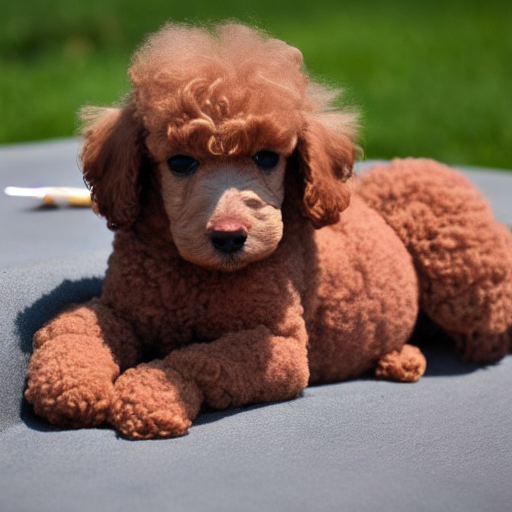

In [ ]:
prompt = "a 2 month old poodle"
image = pipe(prompt, num_inference_steps=30, guidance_scale=7.5).images[0]
image

In [ ]:
!python age_editing.py \
  --image_path "test_poodle.jpg" \
  --age_init 39 \
  --specialized_path "poodle_fading_model" \
  --save_aged_dir "poodle_outputs" \
  --target_ages 6 36 84

2025-11-23 02:06:41.935471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763863601.956674   10060 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763863601.963092   10060 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763863601.979138   10060 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763863601.979175   10060 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763863601.979178   10060 computation_placer.cc:177] computation placer alr